<a href="https://colab.research.google.com/github/ericaburdett/DS-Unit-1-Build/blob/master/hfi_whr062620.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas-profiling==2.*
!pip install category_encoders==2.*
!pip install eli5
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
import category_encoders as ce
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import shap

In [ ]:
# Change pandas options for viewing

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Getting the data

In [ ]:
# Import Human Freedom Index (2008-2017)
# Missing values were encoded as '-'

hfi = pd.read_csv('https://object.cato.org/sites/cato.org/files/human-freedom-index-files/human-freedom-index-2019.csv',
                  na_values='-')

In [ ]:
print(hfi.shape)
hfi.head()

(1620, 120)


,year,ISO_code,countries,region,hf_score,hf_rank,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol,pf_ss_homicide,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_injuries,pf_ss_disappearances,pf_ss_women_fgm,pf_ss_women_inheritance_widows,pf_ss_women_inheritance_daughters,pf_ss_women_inheritance,pf_ss_women,pf_ss,pf_movement_domestic,pf_movement_foreign,pf_movement_women,pf_movement,pf_religion_estop_establish,pf_religion_estop_operate,pf_religion_estop,pf_religion_harassment,pf_religion_restrictions,pf_religion,pf_association_association,pf_association_assembly,pf_association_political_establish,pf_association_political_operate,pf_association_political,pf_association_prof_establish,pf_association_prof_operate,pf_association_prof,pf_association_sport_establish,pf_association_sport_operate,pf_association_sport,pf_association,pf_expression_killed,pf_expression_jailed,pf_expression_influence,pf_expression_control,pf_expression_cable,pf_expression_newspapers,pf_expression_internet,pf_expression,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_government_consumption,ef_government_transfers,ef_government_enterprises,ef_government_tax_income,ef_government_tax_payroll,ef_government_tax,ef_government_soa,ef_government,ef_legal_judicial,ef_legal_courts,ef_legal_protection,ef_legal_military,ef_legal_integrity,ef_legal_enforcement,ef_legal_restrictions,ef_legal_police,ef_legal_crime,ef_legal_gender,ef_legal,ef_money_growth,ef_money_sd,ef_money_inflation,ef_money_currency,ef_money,ef_trade_tariffs_revenue,ef_trade_tariffs_mean,ef_trade_tariffs_sd,ef_trade_tariffs,ef_trade_regulatory_nontariff,ef_trade_regulatory_compliance,ef_trade_regulatory,ef_trade_black,ef_trade_movement_foreign,ef_trade_movement_capital,ef_trade_movement_visit,ef_trade_movement,ef_trade,ef_regulation_credit_ownership,ef_regulation_credit_private,ef_regulation_credit_interest,ef_regulation_credit,ef_regulation_labor_minwage,ef_regulation_labor_firing,ef_regulation_labor_bargain,ef_regulation_labor_hours,ef_regulation_labor_dismissal,ef_regulation_labor_conscription,ef_regulation_labor,ef_regulation_business_adm,ef_regulation_business_bureaucracy,ef_regulation_business_start,ef_regulation_business_bribes,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,ef_rank
0,2017,ALB,Albania,Eastern Europe,7.84,38.0,1.0,6.7,4.5,4.7,5.3,9.1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,7.5,8.8,9.3,10.0,10.0,10.0,10.0,NaN,NaN,10.0,9.6,8.0,9.2,10.0,10.0,NaN,NaN,10.0,NaN,NaN,10.0,NaN,NaN,10.0,10.0,10.0,10.0,5.0,5.3,10.0,10.0,10.0,8.6,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,8.1,7.3,8.0,9.0,7.0,8.0,6.2,7.5,2.5,3.1,4.6,8.3,4.2,4.4,6.6,6.8,6.2,1.0,5.1,9.3,9.7,9.6,10.0,9.6,9.6,9.3,8.1,9.0,6.0,9.4,7.7,10.0,6.3,5.4,8.3,6.7,8.3,10.0,9.1,10.0,9.7,5.6,5.4,6.4,8.0,6.3,10.0,6.9,6.3,6.7,9.7,4.1,6.0,7.2,6.7,7.8,7.67,30.0
1,2017,DZA,Algeria,Middle East & North Africa,4.99,155.0,4.0,NaN,NaN,NaN,3.8,9.5,10.0,9.5,5.0,9.9,9.9,8.9,10.0,NaN,NaN,0.0,5.0,7.8,10.0,5.0,2.5,5.8,NaN,NaN,5.0,6.9,3.0,4.9,5.0,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,5.0,10.0,9.5,2.7,4.0,10.0,7.5,7.5,7.3,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,2.7,7.8,0.0,7.0,2.0,4.5,2.9,3.6,4.3,4.3,4.8,4.2,5.0,4.4,6.6,6.1,6.7,0.8,4.7,7.0,8.5,8.9,5.0,7.3,8.5,6.2,5.9,6.9,4.8,0.5,2.6,0.0,3.7,0.0,1.1,1.6,2.8,0.0,5.3,10.0,5.1,5.6,4.1,6.0,6.0,7.8,3.0,5.4,3.7,1.8,9.3,3.8,8.7,7.0,5.7,5.4,4.77,159.0
2,2017,AGO,Angola,Sub-Saharan Africa,5.40,151.0,4.0,NaN,NaN,NaN,3.4,8.1,10.0,9.7,7.5,9.9,7.2,8.9,10.0,NaN,NaN,5.0,7.5,8.1,5.0,5.0,10.0,6.7,NaN,NaN,10.0,8.9,7.5,8.8,2.5,2.5,NaN,NaN,2.5,NaN,NaN,5.0,NaN,NaN,7.5,4.0,10.0,10.0,2.7,2.5,7.5,5.0,7.5,6.5,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,6.3,8.9,6.0,10.0,9.0,9.5,3.1,6.8,1.4,1.7,3.3,3.3,4.2,2.3,5.5,3.4,4.3,0.8,3.0,9.4,4.2,3.7,5.0,5.6,9.2,7.7,4.3,7.1,4.9,2.5,3.7,0.0,2.9,3.1,0.1,2.0,3.2

In [ ]:
# Only have happiness data for 2015-2017 so only need that from Human Freedom Index

hfi = hfi[hfi['year'] >= 2015]

In [ ]:
hfi.year.value_counts()

2017    162
2016    162
2015    162
Name: year, dtype: int64

In [ ]:
# Rename 'countries' to 'Country' to be consistent with WHR data

hfi = hfi.rename(columns={'countries': 'Country'})

In [ ]:
hfi.shape

(486, 120)

In [ ]:
# Import World Happiness Report 2015
# Only need 'Country' and 'Happiness Score'

whr_2015 = pd.read_csv('https://raw.githubusercontent.com/ericaburdett/Human-Freedom-and-Happiness/master/2015.csv',
                       usecols=['Country', 'Happiness Score'])

In [ ]:
# Add year column 
whr_2015['year'] = 2015

In [ ]:
print(whr_2015.shape)
whr_2015.head()

(158, 3)


,Country,Happiness Score,year
0,Switzerland,7.587,2015
1,Iceland,7.561,2015
2,Denmark,7.527,2015
3,Norway,7.522,2015
4,Canada,7.427,2015


In [ ]:
# Import World Happiness Report 2016
# Only need 'Country' and 'Happiness Score'
 
whr_2016 = pd.read_csv('https://raw.githubusercontent.com/ericaburdett/Human-Freedom-and-Happiness/master/2016.csv',
                       usecols=['Country', 'Happiness Score'])

In [ ]:
# Add year column 

whr_2016['year'] = 2016

In [ ]:
print(whr_2016.shape)
whr_2016.head()

(157, 3)


,Country,Happiness Score,year
0,Denmark,7.526,2016
1,Switzerland,7.509,2016
2,Iceland,7.501,2016
3,Norway,7.498,2016
4,Finland,7.413,2016


In [ ]:
# Import World Happiness Report 2017
# Only need 'Country' and 'Happiness.Score'
 
whr_2017 = pd.read_csv('https://raw.githubusercontent.com/ericaburdett/Human-Freedom-and-Happiness/master/2017.csv',
                       usecols=['Country', 'Happiness.Score'])

In [ ]:
whr_2017['year'] = 2017

In [ ]:
print(whr_2017.shape)
whr_2017.head()

(155, 3)


,Country,Happiness.Score,year
0,Norway,7.537,2017
1,Denmark,7.522,2017
2,Iceland,7.504,2017
3,Switzerland,7.494,2017
4,Finland,7.469,2017


In [ ]:
# Rename 'Happiness.Score' to 'Happiness Score' for consistency

whr_2017 = whr_2017.rename(columns={'Happiness.Score': 'Happiness Score'})

In [ ]:
whr_2017.head()

,Country,Happiness Score,year
0,Norway,7.537,2017
1,Denmark,7.522,2017
2,Iceland,7.504,2017
3,Switzerland,7.494,2017
4,Finland,7.469,2017


In [ ]:
# Merge whr_2015, whr_2016, whr_2017 into whr

whr = whr_2015.append(whr_2016)

In [ ]:
whr = whr.append(whr_2017)

In [ ]:
whr.head()

,Country,Happiness Score,year
0,Switzerland,7.587,2015
1,Iceland,7.561,2015
2,Denmark,7.527,2015
3,Norway,7.522,2015
4,Canada,7.427,2015


In [ ]:
whr.tail()

,Country,Happiness Score,year
150,Rwanda,3.471,2017
151,Syria,3.462,2017
152,Tanzania,3.349,2017
153,Burundi,2.905,2017
154,Central African Republic,2.693,2017


In [ ]:
# whr shape should be (470, 3)

whr.shape

(470, 3)

In [ ]:
# Merge hfi and whr data on Country and year
# Inner join to preserve only rows found in both dataframes

hfi_whr = hfi.merge(whr, how='inner', on=['Country', 'year'])


In [ ]:
hfi_whr.head()

,year,ISO_code,Country,region,hf_score,hf_rank,hf_quartile,pf_rol_procedural,pf_rol_civil,pf_rol_criminal,pf_rol,pf_ss_homicide,pf_ss_disappearances_disap,pf_ss_disappearances_violent,pf_ss_disappearances_organized,pf_ss_disappearances_fatalities,pf_ss_disappearances_injuries,pf_ss_disappearances,pf_ss_women_fgm,pf_ss_women_inheritance_widows,pf_ss_women_inheritance_daughters,pf_ss_women_inheritance,pf_ss_women,pf_ss,pf_movement_domestic,pf_movement_foreign,pf_movement_women,pf_movement,pf_religion_estop_establish,pf_religion_estop_operate,pf_religion_estop,pf_religion_harassment,pf_religion_restrictions,pf_religion,pf_association_association,pf_association_assembly,pf_association_political_establish,pf_association_political_operate,pf_association_political,pf_association_prof_establish,pf_association_prof_operate,pf_association_prof,pf_association_sport_establish,pf_association_sport_operate,pf_association_sport,pf_association,pf_expression_killed,pf_expression_jailed,pf_expression_influence,pf_expression_control,pf_expression_cable,pf_expression_newspapers,pf_expression_internet,pf_expression,pf_identity_legal,pf_identity_sex_male,pf_identity_sex_female,pf_identity_sex,pf_identity_divorce,pf_identity,pf_score,pf_rank,ef_government_consumption,ef_government_transfers,ef_government_enterprises,ef_government_tax_income,ef_government_tax_payroll,ef_government_tax,ef_government_soa,ef_government,ef_legal_judicial,ef_legal_courts,ef_legal_protection,ef_legal_military,ef_legal_integrity,ef_legal_enforcement,ef_legal_restrictions,ef_legal_police,ef_legal_crime,ef_legal_gender,ef_legal,ef_money_growth,ef_money_sd,ef_money_inflation,ef_money_currency,ef_money,ef_trade_tariffs_revenue,ef_trade_tariffs_mean,ef_trade_tariffs_sd,ef_trade_tariffs,ef_trade_regulatory_nontariff,ef_trade_regulatory_compliance,ef_trade_regulatory,ef_trade_black,ef_trade_movement_foreign,ef_trade_movement_capital,ef_trade_movement_visit,ef_trade_movement,ef_trade,ef_regulation_credit_ownership,ef_regulation_credit_private,ef_regulation_credit_interest,ef_regulation_credit,ef_regulation_labor_minwage,ef_regulation_labor_firing,ef_regulation_labor_bargain,ef_regulation_labor_hours,ef_regulation_labor_dismissal,ef_regulation_labor_conscription,ef_regulation_labor,ef_regulation_business_adm,ef_regulation_business_bureaucracy,ef_regulation_business_start,ef_regulation_business_bribes,ef_regulation_business_licensing,ef_regulation_business_compliance,ef_regulation_business,ef_regulation,ef_score,ef_rank,Happiness Score
0,2017,ALB,Albania,Eastern Europe,7.84,38.0,1.0,6.7,4.5,4.7,5.3,9.1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,NaN,7.5,8.8,9.3,10.0,10.0,10.0,10.0,NaN,NaN,10.0,9.6,8.0,9.2,10.0,10.0,NaN,NaN,10.0,NaN,NaN,10.0,NaN,NaN,10.0,10.0,10.0,10.0,5.0,5.3,10.0,10.0,10.0,8.6,0.0,10.0,10.0,10.0,7.5,5.8,8.01,46.0,8.1,7.3,8.0,9.0,7.0,8.0,6.2,7.5,2.5,3.1,4.6,8.3,4.2,4.4,6.6,6.8,6.2,1.0,5.1,9.3,9.7,9.6,10.0,9.6,9.6,9.3,8.1,9.0,6.0,9.4,7.7,10.0,6.3,5.4,8.3,6.7,8.3,10.0,9.1,10.0,9.7,5.6,5.4,6.4,8.0,6.3,10.0,6.9,6.3,6.7,9.7,4.1,6.0,7.2,6.7,7.8,7.67,30.0,4.644
1,2017,DZA,Algeria,Middle East & North Africa,4.99,155.0,4.0,NaN,NaN,NaN,3.8,9.5,10.0,9.5,5.0,9.9,9.9,8.9,10.0,NaN,NaN,0.0,5.0,7.8,10.0,5.0,2.5,5.8,NaN,NaN,5.0,6.9,3.0,4.9,5.0,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,5.0,10.0,9.5,2.7,4.0,10.0,7.5,7.5,7.3,NaN,0.0,0.0,0.0,0.0,0.0,5.20,146.0,2.7,7.8,0.0,7.0,2.0,4.5,2.9,3.6,4.3,4.3,4.8,4.2,5.0,4.4,6.6,6.1,6.7,0.8,4.7,7.0,8.5,8.9,5.0,7.3,8.5,6.2,5.9,6.9,4.8,0.5,2.6,0.0,3.7,0.0,1.1,1.6,2.8,0.0,5.3,10.0,5.1,5.6,4.1,6.0,6.0,7.8,3.0,5.4,3.7,1.8,9.3,3.8,8.7,7.0,5.7,5.4,4.77,159.0,5.872
2,2017,AGO,Angola,Sub-Saharan Africa,5.40,151.0,4.0,NaN,NaN,NaN,3.4,8.1,10.0,9.7,7.5,9.9,7.2,8.9,10.0,NaN,NaN,5.0,7.5,8.1,5.0,5.0,10.0,6.7,NaN,NaN,10.0,8.9,7.5,8.8,2.5,2.5,NaN,NaN,2.5,NaN,NaN,5.0,NaN,NaN,7.5,4.0,10.0,10.0,2.7,2.5,7.5,5.0,7.5,6.5,10.0,0.0,0.0,0.0,5.0,5.0,5.98,121.0,6.3,8.9,6.0,10.0,9.0,9.5,3.1,6.8,1.4,1.7,3.3,3.3,4.2,2.3,5.5,3.4,4.3,0.8,3.0,9.4,4.2,3.7,5.0,5.6,9.2,7.7,4.3,7.1,4.9,2.5,3

In [ ]:
# Run pandas profile

#profile = ProfileReport(hfi_whr, minimal=True).to_file('hfi_whr.html')

# Data Wrangling

In [ ]:
# Drop columns with high cardinality (according to Pandas Profile)
hfi_whr = hfi_whr.drop(columns=['ISO_code', 'Country'])

# Drop columns with more than 30% missing values (according to Pandas Profile)
hfi_whr = hfi_whr.drop(columns=['pf_rol_procedural', 'pf_rol_civil', 'pf_rol_criminal',
                                'pf_ss_women_inheritance_widows', 'pf_ss_women_inheritance_daughters',
                                'pf_identity_legal', 'ef_regulation_labor_dismissal'])

# Drop 100% missing columns (According to Pandas Profile)
hfi_whr = hfi_whr.drop(columns=['pf_religion_estop_establish', 'pf_religion_estop_operate',
                                'pf_association_political_establish', 'pf_association_political_operate',
                                'pf_association_prof_establish', 'pf_association_prof_operate',
                                'pf_association_sport_establish', 'pf_association_sport_operate'])

# Drop columns with unusable variance
hfi_whr = hfi_whr.drop(columns=['hf_rank', 'pf_rank', 'ef_rank'])


In [ ]:
hfi_whr.shape


(407, 101)

# Correlation?


In [ ]:
# Hypothesis: There is a positive correlation between freedom and happiness.

# Rename 'hf_score' to 'Freedom Score'
hfi_whr = hfi_whr.rename(columns={'hf_score': 'Freedom Score'})

# Run correlation matrix between 'Freedom Score' and 'Happiness Score'
hfi_whr_corr = hfi_whr[['Freedom Score', 'Happiness Score']]
hfi_whr_corr.corr()

,Freedom Score,Happiness Score
Freedom Score,1.000000,0.583164
Happiness Score,0.583164,1.000000


# Baseline

In [ ]:
# Use mean as prediction for every row
guess = hfi_whr['Happiness Score'].mean()
errors = guess - hfi_whr['Happiness Score']

# Calculate Mean Absolute Error
mae = errors.abs().mean()
print(f'Mean absolute error: {mae:.2f}')

Mean absolute error: 0.97


# Train / Val / Test Split

In [ ]:
# Train / test split
train, test = train_test_split(hfi_whr, train_size=0.80, random_state=42)

# Train / val split
train, val = train_test_split(train, train_size=0.80, random_state=42)

train.shape, test.shape, val.shape

((260, 101), (82, 101), (65, 101))

In [ ]:
# Set up target and features
target = 'Happiness Score'
features = hfi_whr.columns.drop([target])

In [ ]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# Ridge Regression


In [ ]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    SelectKBest(),
    Ridge()
)

param_dist = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'selectkbest__k': range(1, len(X_train.columns) + 1),
    'ridge__alpha': [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=100, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1907s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1803s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   11.5s
[Parallel(n_jo

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=None,
                                                             drop_invariant=False,
                                                             handle_missing='value',
                                                             handle_unknown='value',
                                                             mapping=None,
                                                             return_df=True,
                                                             verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,


In [ ]:
print('Best hyperparameters', search.best_params_)


Best hyperparameters {'simpleimputer__strategy': 'most_frequent', 'selectkbest__k': 93, 'ridge__alpha': 10}


In [ ]:
y_pred = search.predict(X_val)
mae = mean_absolute_error(y_val, y_pred)
print(f'Validation MAE: {mae:,.2f}')

Validation MAE: 0.54


# XGBoost

In [ ]:
pipeline2 = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    SelectKBest(),
    XGBRegressor()
)

param_dist = {
    'simpleimputer__strategy': ['mean', 'median', 'most_frequent'],
    'selectkbest__k': range(1, len(X_train.columns)+1),
    'xgbregressor__n_estimators': randint(50, 500), 
    'xgbregressor__max_depth': [5, 10, 15, 20, None], 
    'xgbregressor__max_features': uniform(0, 1)
}

search2 = RandomizedSearchCV(
    pipeline2,
    param_distributions=param_dist,
    n_iter=100, 
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search2.fit(X_train, y_train)

print('Best hyperparameters', search2.best_params_)

y_pred2 = search2.predict(X_val)
mae = mean_absolute_error(y_val, y_pred2)
print(f'Validation MAE: {mae:,.2f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   32.0s
[Paralle

[01:50:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best hyperparameters {'selectkbest__k': 64, 'simpleimputer__strategy': 'mean', 'xgbregressor__max_depth': 15, 'xgbregressor__max_features': 0.42976067607772594, 'xgbregressor__n_estimators': 473}
Validation MAE: 0.27


# Test the model

In [ ]:
y_pred = search2.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: {mae:,.2f}')

Test MAE: 0.25


# Permutation Importances

In [ ]:
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)


model = XGBRegressor(max_depth=10, max_features=0.6652168002642086, 
                     n_estimators=482, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

[01:50:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=10, max_features=0.6652168002642086, min_child_weight=1,
             missing=None, n_estimators=482, n_jobs=-1, nthread=None,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=None, silent=None, subsample=1,
             verbosity=1)

In [ ]:
permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.1,
                                             max_delta_step=0, max_depth=10,
                                             max_features=0.6652168002642086,
                                             min_child_weight=1, missing=None,
                                             n_estimators=482, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:linear',
                                             random_state=42, reg_alpha=0,
                                     

In [ ]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

pf_rol                                0.239433
region                                0.153826
ef_regulation_business_bribes         0.074878
ef_trade_movement_foreign             0.063158
ef_regulation_business_bureaucracy    0.059244
pf_ss_women_fgm                       0.057061
ef_government_consumption             0.052788
ef_legal                              0.052012
pf_score                              0.045215
ef_trade_tariffs_mean                 0.039759
ef_trade_tariffs_sd                   0.035088
ef_legal_integrity                    0.034482
ef_government_transfers               0.032352
pf_ss_homicide                        0.030989
ef_legal_judicial                     0.027268
pf_expression                         0.021182
ef_trade_tariffs_revenue              0.020765
pf_religion_restrictions              0.020629
ef_trade_movement_visit               0.020574
pf_religion                           0.013788
ef_regulation_labor_conscription      0.010262
ef_trade_move

In [ ]:
eli5.show_weights(
    permuter, 
    top=None, # Shows all features,
    feature_names=feature_names
)

Weight,Feature
0.2394 ± 0.0466,pf_rol
0.1538 ± 0.0580,region
0.0749 ± 0.0160,ef_regulation_business_bribes
0.0632 ± 0.0147,ef_trade_movement_foreign
0.0592 ± 0.0160,ef_regulation_business_bureaucracy
0.0571 ± 0.0192,pf_ss_women_fgm
0.0528 ± 0.0113,ef_government_consumption
0.0520 ± 0.0188,ef_legal
0.0452 ± 0.0067,pf_score
0.0398 ± 0.0282,ef_trade_tariffs_mean


#PDP_isolate

In [ ]:
feature = 'ef_money_growth'

isolated = pdp_isolate(
    model = search2,
    dataset=X_test,
    model_features = X_test.columns,
    feature=feature,
    num_grid_points=50
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


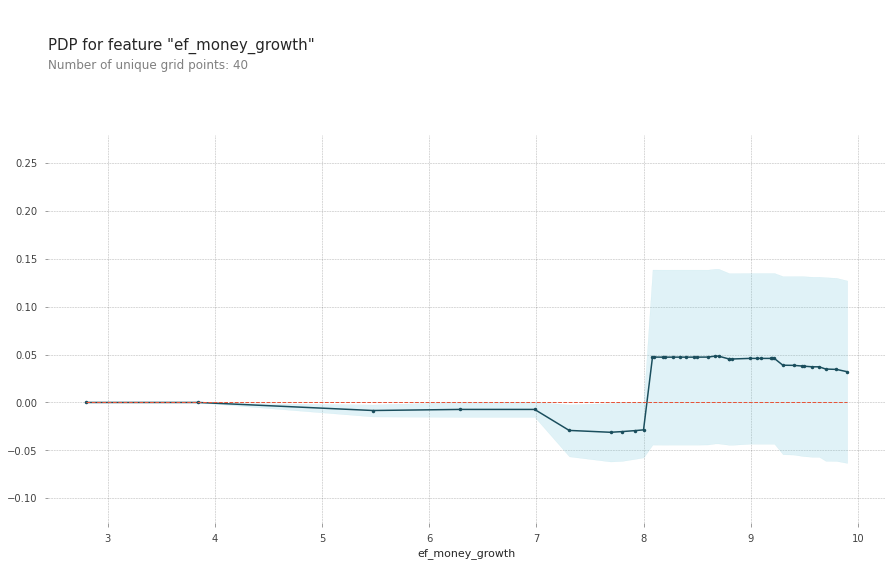

In [ ]:
pdp_plot(isolated, feature_name=feature);

#PDP_interact

In [ ]:
features = ['ef_money_growth', 'ef_money_inflation']

interaction = pdp_interact(
    model=search2, 
    dataset=X_test,
    model_features=X_test.columns,
    features=features
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


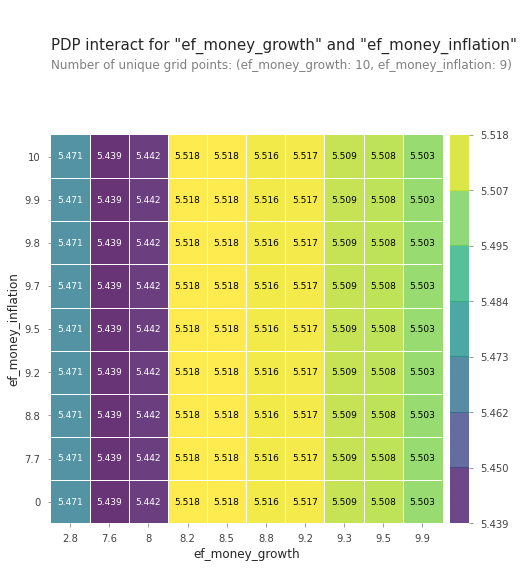

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);